# Mass preserving operations on the H3 grid

Problem statement : We want to assign values to a large set of cell, while respecting a spatial pattern represented by a distribution on a small subset of those cells. 
- Pycnophylactic (mass preserving) : we want the values to add up to the original total. 
- We want to express everything through the H3 grid cell hierarchy

## References




## Important operations

- k-nearest neighbours
- Hex kernels (from knn)
- cells along a line between two known cells
- Basic Voronoi from a seed of cells
- Network Voronoi from a H3 embedded network.

## 

In [149]:
import re
import itertools as iter
import numpy as np
import random
# data
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely as shp

import h3
import scalenav.data as snd
import scalenav.scale_nav as sn
import scalenav.oop as snoo
from scalenav.plotting import cmap

import ibis as ib
from ibis import _
ib.options.interactive = True


In [4]:
from parameters import *

/Users/cenv1069/Documents/data/notebooks


In [5]:
##
conn = snoo.sn_connect()

Connecting to a temporary in-memory DB instance.


In [6]:
sample_size = 5

In [7]:
boundary = {"xmin" : -0.18823,
            "ymin" : 51.49175,
            "xmax" : -0.09356,
            "ymax" : 51.54009}

In [8]:
lon = -0.15
lat = 51.52
h3_res = 9

band_var = 10

### K ring

In [9]:
cell = conn.sql(f"""
SELECT h3_latlng_to_cell_string({lat},{lon},{h3_res}) as cell;
""")
cell

┏━━━━━━━━━━━━━━━━━┓
┃ cell            ┃
┡━━━━━━━━━━━━━━━━━┩
│ string          │
├─────────────────┤
│ 89195da49dbffff │
└─────────────────┘

In [10]:
ring = cell.alias("tab").sql("SELECT h3_grid_disk(cell,1) as kring from tab;")
ring

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ kring                                          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ array<string>                                  │
├────────────────────────────────────────────────┤
│ ['89195da49dbffff', '89195da48afffff', ... +5] │
└────────────────────────────────────────────────┘

In [11]:
gpd.GeoSeries.from_wkt(ring.alias("tab2").sql("""SELECT (h3_cell_to_boundary_wkt(unnest(kring))) as kring from tab2;""").execute()["kring"],crs="epsg:4326").explore()

### Inverse distance weighting (IDW)

## Voronoi

In [12]:
area_oi = shp.box(**boundary)

In [13]:
seed_lon = np.random.uniform(low=boundary["xmin"],high=boundary["xmax"],size=sample_size)
seed_lat = np.random.uniform(low=boundary["ymin"],high=boundary["ymax"],size=sample_size)

In [14]:
seed = gpd.GeoSeries(shp.MultiPoint([shp.Point([x,y]) for (x,y) in zip(seed_lon,seed_lat)]),crs="epsg:4326")

In [15]:
voronoi_geom = pd.DataFrame({"geom" : shp.voronoi_polygons(seed,extend_to=area_oi).explode().intersection(area_oi).reset_index(drop=True).to_wkt()})

In [16]:
voronoi_geom["geom"] = voronoi_geom.apply(lambda x : x["geom"],axis=1)

In [17]:
# ib.Table(voronoi_geom)
gpd.GeoSeries.from_wkt(voronoi_geom.geom,crs="epsg:4326").explore()

In [18]:
conn.create_table("voronoi",obj=voronoi_geom,overwrite=True)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ geom                                                                             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string                                                                           │
├──────────────────────────────────────────────────────────────────────────────────┤
│ POLYGON ((-0.154092 51.514376, -0.154532 51.512216, -0.18823 51.521237, -0.1882… │
│ POLYGON ((-0.154532 51.512216, -0.150074 51.49175, -0.18823 51.49175, -0.18823 … │
│ POLYGON ((-0.154092 51.514376, -0.12742 51.54009, -0.108586 51.54009, -0.131065… │
│ POLYGON ((-0.154092 51.514376, -0.164011 51.54009, -0.12742 51.54009, -0.154092… │
│ POLYGON ((-0.108586 51.54009, -0.09356 51.54009, -0.09356 51.49175, -0.131065 5… │
└──────────────────────────────────────────────────────────────────────────────────┘

In [19]:
conn.raw_sql(f"""
CREATE OR REPLACE SEQUENCE id_sequence START 1;
""")


In [20]:
voronoi_cells_df = conn.sql(f"""
         SELECT id, ST_GeomFromText(h3_cell_to_boundary_wkt(unnest(voronoi_cells))) as geom, unnest(voronoi_cells) as h3_id from 
(Select nextval('id_sequence') as id,
        h3_polygon_wkt_to_cells_string(geom,{h3_res}) as voronoi_cells from voronoi);
""").execute()

In [21]:
voronoi_cells_df.set_crs(epsg=4326,inplace=True)
voronoi_cells_df.explore("id")

## Strict H3 Voronoi
Use exclusively H3 functionality to compute the Voronoids.

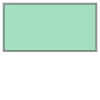

In [22]:
area_oi

In [23]:
seed_h3 = [h3.latlng_to_cell(lat=y,lng=x,res=h3_res) for (x,y) in zip(seed_lon,seed_lat)]

In [24]:
seed_h3

['89194ad3203ffff',
 '89195da4c23ffff',
 '89195da4843ffff',
 '89195da4d2fffff',
 '89195da4b0bffff']

In [25]:
def h3_voronoi(seed : list,boundary : shp.box,nn_param_lim : int = 15):
    
    h3_aoi = h3.geo_to_cells(boundary,res=h3_res)
    h3_voronoi = {seed_ : [seed_] for seed_ in seed}
    for el in seed:
        h3_aoi.remove(el)
    
    nn_param = 1
    while h3_aoi and nn_param<nn_param_lim:
        for seed_ in h3_voronoi.keys():
            disk = h3.grid_disk(seed_,nn_param)
            for el in disk:
                if el in h3_aoi:
                    h3_aoi.remove(el)
                    h3_voronoi[seed_].append(el)
        nn_param=nn_param+1

    return {seed_ : list(set(vals)) for seed_,vals in h3_voronoi.items()}
        

In [26]:
h3_vor = h3_voronoi(seed=seed_h3,boundary=area_oi)

In [27]:
h3_voronoi_df = pd.DataFrame(list(h3_vor.items()),columns=["seed","h3_cells"])

In [28]:
h3_voronoi_df.head()

,seed,h3_cells
0,89194ad3203ffff,"[89194ad3273ffff, 89194ad362bffff, 89194ad32d3..."
1,89195da4c23ffff,"[89195da4c6fffff, 89195da4883ffff, 89195da4d1b..."
2,89195da4843ffff,"[89195da4a83ffff, 89195da484bffff, 89195da4873..."
3,89195da4d2fffff,"[89195da490bffff, 89195da4907ffff, 89195da49cf..."
4,89195da4b0bffff,"[89194ad1653ffff, 89195da4b8fffff, 89195da4b87..."


In [29]:
h3_voronoi_geom = {seed_ : h3.cells_to_h3shape(vals) for seed_,vals in h3_vor.items()}

In [30]:
h3_voronoi_geom

{'89194ad3203ffff': <H3Poly: [96]>,
 '89195da4c23ffff': <H3Poly: [70]>,
 '89195da4843ffff': <H3Poly: [60]>,
 '89195da4d2fffff': <H3Poly: [84]>,
 '89195da4b0bffff': <H3Poly: [72]>}

In [31]:
gpd.GeoSeries(h3.cells_to_h3shape(seed_h3),crs="epsg:4326").explore()

In [32]:
h3_voronoi_df = pd.DataFrame.from_dict(h3_voronoi_geom,orient="index",columns=["geom"])

In [33]:
h3_voronoi_df

,geom
89194ad3203ffff,<H3Poly: [96]>
89195da4c23ffff,<H3Poly: [70]>
89195da4843ffff,<H3Poly: [60]>
89195da4d2fffff,<H3Poly: [84]>
89195da4b0bffff,<H3Poly: [72]>


In [34]:
gpd.GeoDataFrame(h3_voronoi_df,geometry="geom",crs="epsg:4326").explore()

## Networks

node ids: h3 ids, locations with production values and other local variables

edges : links between nodes, distance informed by geography, transport cost, amount of trade etc...

### Scale change

Similarly to the static data case, data can be aggregated or disaggregated at resolution change on a network.
- At resolution decrease, collapse, we add up all the flows into parent cell. Nodes are combined additively as well.
- At resolution increase, uniform distribution across a fully connected subgraph of the children cells. Or rescaled distribution across a given proxy data set. 

In [35]:
import networkx as nx
import h3

In [36]:
nodes_sample = 10

nodes_from = voronoi_cells_df["h3_id"].sample(nodes_sample).reset_index(drop=True)
nodes_to = voronoi_cells_df["h3_id"].sample(nodes_sample).reset_index(drop=True)

exp_scale = 0.2

weights = np.random.exponential(size=nodes_sample,scale=exp_scale).tolist()

dist = [np.round(h3.great_circle_distance(h3.cell_to_latlng(x),h3.cell_to_latlng(y)),2) for (x,y) in zip(nodes_from,nodes_to)]

In [37]:
h3_net = conn.create_table(obj={"from" : nodes_from,
                       "to" : nodes_to,
                       "weight_var" : weights,
                       "dist" : dist},
                       name="h3_net",
                       overwrite=True)

In [38]:
voronoi_cells_df["weight_var"] = np.random.exponential(exp_scale,size=voronoi_cells_df.shape[0])

In [39]:
h3_net

┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┓
┃ from            ┃ to              ┃ weight_var ┃ dist    ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━┩
│ string          │ string          │ float64    │ float64 │
├─────────────────┼─────────────────┼────────────┼─────────┤
│ 89194ad3287ffff │ 89195da490bffff │   0.082369 │    3.35 │
│ 89194ad3653ffff │ 89195da4dc3ffff │   0.422645 │    1.81 │
│ 89195da492bffff │ 89194ada597ffff │   0.058313 │    2.27 │
│ 89194ad16cfffff │ 89195da4c23ffff │   0.083996 │    4.86 │
│ 89195da4dcbffff │ 89195da48cbffff │   0.232986 │    2.24 │
│ 89195da4e27ffff │ 89195da4827ffff │   0.284625 │    2.43 │
│ 89194ad360fffff │ 89195da4b53ffff │   0.800868 │    6.11 │
│ 89194ad3613ffff │ 89194ad3607ffff │   0.840157 │    0.59 │
│ 89194ad16dbffff │ 89194ad14dbffff │   0.074880 │    2.24 │
│ 89195da4987ffff │ 89194ad3353ffff │   0.133401 │    2.71 │
└─────────────────┴─────────────────┴────────────┴─────────┘

In [40]:
conn.sql("""
    SELECT h3_cell_to_latlng(h3_net.from) as from_coord,
            h3_cell_to_latlng(h3_net.to) as to_coord, 
            from h3_net;
""")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ from_coord                                 ┃ to_coord                                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ array<float64>                             │ array<float64>                             │
├────────────────────────────────────────────┼────────────────────────────────────────────┤
│ [51.514359344307685, -0.09931063398405246] │ [51.509500058275385, -0.1471374029696748]  │
│ [51.53510873845905, -0.10912446547437109]  │ [51.536559239510424, -0.13517831643968162] │
│ [51.50174470666409, -0.14287445856532957]  │ [51.494998186171756, -0.1738896162928155]  │
│ [51.495644174447115, -0.1600383113471189]  │ [51.53864593497827, -0.14737894249825795]  │
│ [51.53634598778601, -0.13979768574205098]  │ [51.53484789748289, -0.17213742803545612]  │
│ [51.53463312317873, -0.17675798446751342]  │ [51.51704068117805, -0.15602005095285817]  │
│ [51.52756661820874, -0.10024877540685692]  │ [51.51302207034757, -0.18538954818513817]  │
│ [51.53301853932829, -0.09693000098518152]  │ [51.52777847197141, -0.09563153772671934]  │
│ [51.500886297335036, -0.16134267167372712] │ [51.50238651720935, -0.12902485635103772]  │
│ [51.512869301545535, -0.13162775464192747] │ [51.4984236846859, -0.10003141459206644]   │
└────────────────────────────────────────────┴────────────────────────────────────────────┘

In [41]:
conn.sql("""
    SELECT ST_POINT(from_coord[1],from_coord[2]) as geometry from
    (SELECT *,
            h3_cell_to_latlng(h3_net.from) as from_coord,
            h3_cell_to_latlng(h3_net.to) as to_coord, 
            from h3_net) as h3_net_coords;
         """)

┏━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ geometry                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ geospatial:geometry     │
├─────────────────────────┤
│ <POINT (51.514 -0.099)> │
│ <POINT (51.535 -0.109)> │
│ <POINT (51.502 -0.143)> │
│ <POINT (51.496 -0.16)>  │
│ <POINT (51.536 -0.14)>  │
│ <POINT (51.535 -0.177)> │
│ <POINT (51.528 -0.1)>   │
│ <POINT (51.533 -0.097)> │
│ <POINT (51.501 -0.161)> │
│ <POINT (51.513 -0.132)> │
└─────────────────────────┘

In [42]:
conn.sql("""
    SELECT * EXCLUDE (from_coord,to_coord), ST_MAKELINE(ST_POINT(from_coord[2],from_coord[1]),ST_POINT(to_coord[2],to_coord[1])) as geometry from
         (SELECT *, h3_cell_to_latlng(h3_net.from) as from_coord,
            h3_cell_to_latlng(h3_net.to) as to_coord, 
            from h3_net) as h3_net_coords 
""")

┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ from            ┃ to              ┃ weight_var ┃ dist    ┃ geometry                                    ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string          │ string          │ float64    │ float64 │ geospatial:geometry                         │
├─────────────────┼─────────────────┼────────────┼─────────┼─────────────────────────────────────────────┤
│ 89194ad3287ffff │ 89195da490bffff │   0.082369 │    3.35 │ <LINESTRING (-0.099 51.514, -0.147 51.51)>  │
│ 89194ad3653ffff │ 89195da4dc3ffff │   0.422645 │    1.81 │ <LINESTRING (-0.109 51.535, -0.135 51.537)> │
│ 89195da492bffff │ 89194ada597ffff │   0.058313 │    2.27 │ <LINESTRING (-0.143 51.502, -0.174 51.495)> │
│ 89194ad16cfffff │ 89195da4c23ffff │   0.083996 │    4.86 │ <LINESTRING (-0.16 51.496, -0.147 51.539)>  │
│ 89195da4dcbffff │ 89195da48cbffff │   0.232986 │    2.24 │ <LINESTRING (-0.14 51.536, -0.172 51.535)>  │
│ 89195da4e27ffff │ 89195da4827ffff │   0.284625 │    2.43 │ <LINESTRING (-0.177 51.535, -0.156 51.517)> │
│ 89194ad360fffff │ 89195da4b53ffff │   0.800868 │    6.11 │ <LINESTRING (-0.1 51.528, -0.185 51.513)>   │
│ 89194ad3613ffff │ 89194ad3607ffff │   0.840157 │    0.59 │ <LINESTRING (-0.097 51.533, -0.096 51.528)> │
│ 89194ad16dbffff │ 89194ad14dbffff │   0.074880 │    2.24 │ <LINESTRING (-0.161 51.501, -0.129 51.502)> │
│ 89195da4987ffff │ 89194ad3353ffff │   0.133401 │    2.71 │ <LINESTRING (-0.132 51.513, -0.1 51.498)>   │
└─────────────────┴─────────────────┴────────────┴─────────┴─────────────────────────────────────────────┘

In [43]:
h3_net_df = conn.sql("""
    SELECT * EXCLUDE (from_coord,to_coord), ST_AsText(ST_MAKELINE(ST_POINT(from_coord[2],from_coord[1]),ST_POINT(to_coord[2],to_coord[1]))) as geometry from
         (SELECT *, h3_cell_to_latlng(h3_net.from) as from_coord,
            h3_cell_to_latlng(h3_net.to) as to_coord, 
            from h3_net) as h3_net_coords;
""").execute()

In [44]:
h3_net_df.head()

,from,to,weight_var,dist,geometry
0,89194ad3287ffff,89195da490bffff,0.082369,3.35,LINESTRING (-0.099310633984052 51.514359344307...
1,89194ad3653ffff,89195da4dc3ffff,0.422645,1.81,LINESTRING (-0.109124465474371 51.535108738459...
2,89195da492bffff,89194ada597ffff,0.058313,2.27,LINESTRING (-0.14287445856533 51.5017447066640...
3,89194ad16cfffff,89195da4c23ffff,0.083996,4.86,LINESTRING (-0.160038311347119 51.495644174447...
4,89195da4dcbffff,89195da48cbffff,0.232986,2.24,LINESTRING (-0.139797685742051 51.536345987786...


In [45]:
# gpd.GeoSeries.from_wkt(h3_net_df["geometry"],crs="epsg:4326")
# gpd.GeoSeries.

In [46]:
h3_net_gdf = gpd.GeoDataFrame(h3_net_df,geometry=gpd.GeoSeries.from_wkt(h3_net_df["geometry"],crs="epsg:4326"))

In [47]:
h3_net_gdf.head()

AttributeError: 'NoneType' object has no attribute 'copy'

,from,to,weight_var,dist,geometry
0,89194ad3287ffff,89195da490bffff,0.082369,3.35,"LINESTRING (-0.09931 51.51436, -0.14714 51.5095)"
1,89194ad3653ffff,89195da4dc3ffff,0.422645,1.81,"LINESTRING (-0.10912 51.53511, -0.13518 51.53656)"
2,89195da492bffff,89194ada597ffff,0.058313,2.27,"LINESTRING (-0.14287 51.50174, -0.17389 51.495)"
3,89194ad16cfffff,89195da4c23ffff,0.083996,4.86,"LINESTRING (-0.16004 51.49564, -0.14738 51.53865)"
4,89195da4dcbffff,89195da48cbffff,0.232986,2.24,"LINESTRING (-0.1398 51.53635, -0.17214 51.53485)"


In [49]:
# fig, ax = plt.subplots(1, 1)
m = voronoi_cells_df.explore(column="weight_var")
h3_net_gdf.explore(m=m,column="weight_var")

## Scale change function for a network.

In [50]:
h3_net_gdf.active_geometry_name

'geometry'

In [167]:
h3_net_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   from        10 non-null     object  
 1   to          10 non-null     object  
 2   weight_var  10 non-null     float64 
 3   dist        10 non-null     float64 
 4   geometry    10 non-null     geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 532.0+ bytes


In [52]:
pd.DataFrame(iter.chain.from_iterable([list(iter.combinations(h3.cell_to_children(x),2)) for x in h3_net_df.to]),columns=["from_new","to_new"])

,from_new,to_new
0,8a195da49087fff,8a195da4908ffff
1,8a195da49087fff,8a195da49097fff
2,8a195da49087fff,8a195da4909ffff
3,8a195da49087fff,8a195da490a7fff
4,8a195da49087fff,8a195da490affff
...,...,...
205,8a194ad3351ffff,8a194ad3352ffff
206,8a194ad3351ffff,8a194ad33537fff
207,8a194ad33527fff,8a194ad3352ffff
208,8a194ad33527fff,8a194ad33537fff


In [166]:
# # df.apply(lambda y : y,axis=1)
# var_columns = [col for col in voronoi_cells_df.columns if re.search(pattern="_var$",string=col)]

# voronoi_intra = voronoi_cells_df.head().copy()

# voronoi_intra["h3_id_intra"] = voronoi_intra["h3_id"].head().apply(lambda x: list(iter.combinations(h3.cell_to_children(x),2)))

# voronoi_intra = voronoi_intra.assign(**{x : voronoi_intra[x]/7**(2) for x in var_columns}).explode("h3_id_intra")

# voronoi_intra[["from","to"]] = list(voronoi_intra.h3_id_intra.values)

# voronoi_intra

In [ ]:


def change_res_net(input : pd.DataFrame, nodes : gpd.GeoDataFrame = None, res : int = 1, central :bool = True,copy : bool = True):
    intra_links_n = 5
    inter_links_n = 2
    # copy as the data will be significantly altered
    if copy:
        input = input.copy()
        nodes_sub = nodes.copy()
    else :
        nodes_sub = nodes
        #.loc[nodes.h3_id.isin(set([*input["from"],*input["to"]]))]

    if input is gpd.GeoDataFrame:
        input.drop(input.active_geometry_name,inplace=True)

    if nodes_sub is gpd.GeoDataFrame:
        print("skipping geom")
        nodes_sub.drop(columns=nodes_sub.active_geometry_name,inplace=True)
    
    var_columns = [col for col in input.columns if re.search(pattern="_var$",string=col)]
    intra_var_transform = {x : lambda df: df[x]/intra_links_n for x in var_columns}
    var_transform = {x : lambda df: df[x]/intra_links_n for x in var_columns}

    if nodes is not None :
        nodes_sub["h3_id_intra"] = nodes_sub["h3_id"].apply(lambda x: random.sample(list(iter.combinations(h3.cell_to_children(x),2)),intra_links_n))

        nodes_sub = nodes_sub.assign(**intra_var_transform).explode("h3_id_intra")

        nodes_sub[["from","to"]] = list(nodes_sub.h3_id_intra.values)

    if central:
        input = input.assign(**{"from" : input["from"].apply(lambda x : random.sample(h3.cell_to_center_child(x),inter_links_n))})
        input = input.assign(**{"to" : input["to"].apply(lambda x : random.sample(h3.cell_to_center_child(x),inter_links_n))})
        return input,sn.change_res(nodes)
    
    else:
        input = input.assign(**{"from" : input["from"].apply(lambda x : random.sample(h3.cell_to_children(x),inter_links_n))})
        input = input.assign(**{"to" : input["to"].apply(lambda x : random.sample(h3.cell_to_children(x),inter_links_n))})

        return pd.concat([input.explode("from").explode("to").assign(**var_transform),nodes_sub[["from","to",*var_columns]]],join="outer"), sn.change_res(nodes)

def h3_to_line(from_cell,to_cell):
    return shp.LineString([h3.cell_to_latlng(from_cell)[::-1],h3.cell_to_latlng(to_cell)[::-1]])


In [225]:
gpd.GeoSeries([h3_to_line(x[0],x[1]) for x in iter.combinations(h3.cell_to_children(h3_net_gdf["from"][1]),2)],crs="epsg:4326").explore()

In [226]:
h3_net_df.head()

,from,to,weight_var,dist,geometry
0,89194ad3287ffff,89195da490bffff,0.082369,3.35,LINESTRING (-0.099310633984052 51.514359344307...
1,89194ad3653ffff,89195da4dc3ffff,0.422645,1.81,LINESTRING (-0.109124465474371 51.535108738459...
2,89195da492bffff,89194ada597ffff,0.058313,2.27,LINESTRING (-0.14287445856533 51.5017447066640...
3,89194ad16cfffff,89195da4c23ffff,0.083996,4.86,LINESTRING (-0.160038311347119 51.495644174447...
4,89195da4dcbffff,89195da48cbffff,0.232986,2.24,LINESTRING (-0.139797685742051 51.536345987786...


In [227]:
h3_net_df_1,voronoi_cells_df_1 = change_res_net(h3_net_gdf,nodes=voronoi_cells_df,res=1,central=False)

Skipping geom


In [228]:
voronoi_cells_df_1 = gpd.GeoDataFrame(voronoi_cells_df_1,geometry=gpd.GeoSeries(voronoi_cells_df_1["h3_id"].apply(lambda x :h3.cells_to_h3shape([x])),crs="epsg:4326"))

In [229]:
h3_net_gdf_1 = gpd.GeoDataFrame(h3_net_df_1,geometry=h3_net_df_1.apply(lambda x: h3_to_line(x["from"],x["to"]),axis=1),crs="epsg:4326")

In [230]:
type(h3_net_gdf_1)
h3_net_gdf_1.shape

(1920, 5)

In [231]:
m = voronoi_cells_df_1.explore(column="weight_var")
h3_net_gdf_1.explore(m=m,weight=1,column="weight_var")

## Uniform flow realocation

The second less trivial case from keeping only a single flow for each downscaled link is to disctribute uniformly across all the new links created.